In [1]:
import vtk
from vtk.util import numpy_support
import os
import numpy
from matplotlib import pyplot, cm
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [24]:
PathDicom = "/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

In [25]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

In [26]:
x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [27]:


# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')



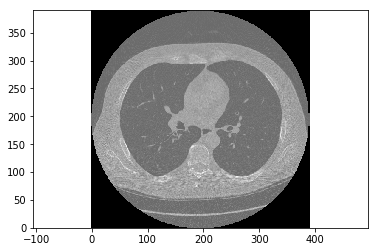

In [28]:
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, numpy.flipud(numpy.rot90(ArrayDicom[:, :, 115])))

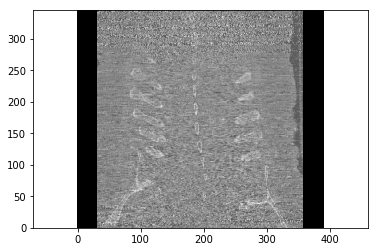

In [29]:


pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, z, numpy.flipud(numpy.rot90(ArrayDicom[:, 115, :])))



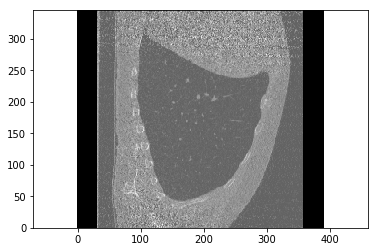

In [30]:
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(y,z , numpy.flipud(numpy.rot90(ArrayDicom[115, :, :])))


In [3]:

%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 


In [4]:
data_path = "/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/"
output_path = working_path = "/home/intern/Documents/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 276 DICOM images.
First 5 filenames:
/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/1.2.826.0.1.3680043.2.656.1.138.11.dcm
/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/1.2.826.0.1.3680043.2.656.1.138.120.dcm
/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/1.2.826.0.1.3680043.2.656.1.138.61.dcm
/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/1.2.826.0.1.3680043.2.656.1.138.117.dcm
/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/1.2.826.0.1.3680043.2.656.1.138.95.dcm


In [5]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)


In [6]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

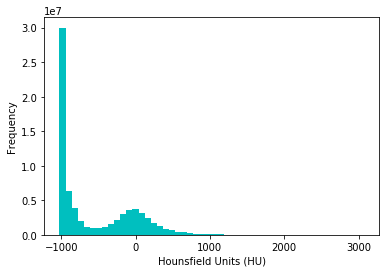

In [7]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

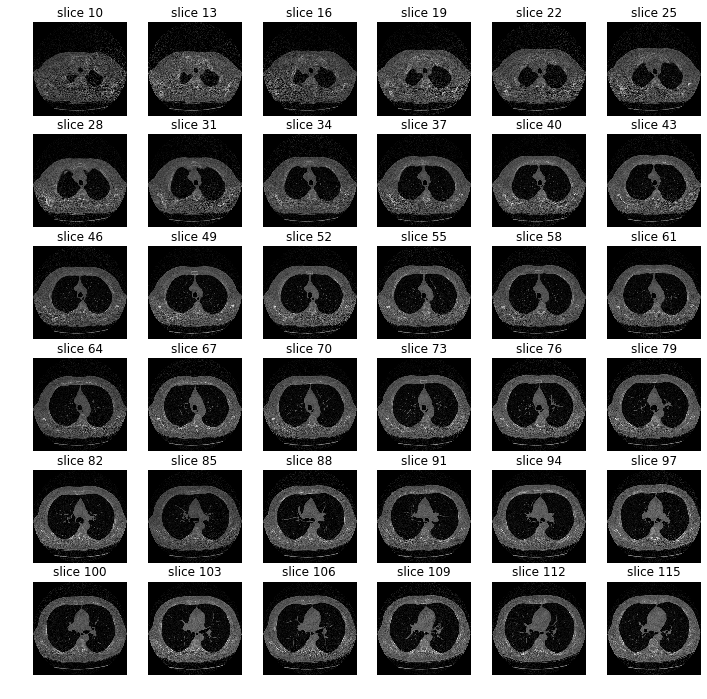

In [8]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)


In [9]:
print ("Slice Thickness: %f" % patient[0].SliceThickness)
print ("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))


Slice Thickness: 1.250000
Pixel Spacing (row, col): (0.761719, 0.761719) 


In [11]:


id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print ("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)



Shape before resampling	 (276, 512, 512)
Shape after resampling	 (345, 390, 390)


In [12]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()

In [13]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

Transposing surface
Calculating surface


AttributeError: module 'skimage.measure' has no attribute 'marching_cubes'